In [1]:
import numpy as np
from PIL import Image
import struct
import matplotlib.pyplot as plt
import math

In [2]:
def read_images(f):
    images = []
    image = None    
    with open(f, "rb") as f:
        # Endianness dependency
        magic_number = int(struct.unpack('i', f.read(4)[::-1])[0])
        number_items = int(struct.unpack('i', f.read(4)[::-1])[0])
        rows = int(struct.unpack('i', f.read(4)[::-1])[0])
        cols = int(struct.unpack('i', f.read(4)[::-1])[0])

        for k in range(0, number_items):
            image = np.zeros([rows, cols])
            for i in range(0, cols):
                for j in range(0, rows):
                    byte = f.read(1)
                    pixel = int(struct.unpack('B', byte)[0])
                    image[i][j] = pixel
    
            images.append(image)
        
    return images

In [3]:
def read_labels(f):
    
    with open(f, "rb") as f:
        # Endianness dependency
        magic_number = struct.unpack('i', f.read(4)[::-1])
        number_items = int(struct.unpack('i', f.read(4)[::-1])[0])
         
        labels = []

        for i in range(0, number_items):
            label = np.zeros(10)
            byte = f.read(1)
            label_val = int(struct.unpack('b', byte)[0])
            for i in range(0, 10):
                label[i] = int(i == label_val)

            labels.append(label)
        

    return labels

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


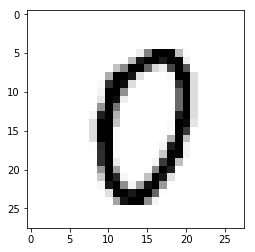

In [4]:
images = read_images("train-images-idx3-ubyte")
labels = read_labels("train-labels-idx1-ubyte")
test_images = read_images("t10k-images-idx3-ubyte")
test_labels = read_labels("t10k-labels-idx1-ubyte")
image = images[1000]
plt.imshow(image, cmap="Greys")
print(labels[1000])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
784


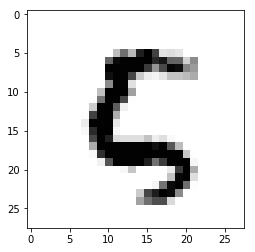

In [6]:
image_e = images[2000]
plt.imshow(image_e, cmap="Greys")
print(labels[2000])
print(image_e.size)

In [7]:
def norm_pixel(pixel):
    return ( (pixel - 127) / 255 )

In [8]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [9]:
class SummationSigmoidLayer:
    def __init__(self, m, n, learning_rate):
        self.size = (m,n)
        self.weights = np.random.rand(m, n) - 0.5
        self.learning_rate = learning_rate
        self.activation_state = np.zeros((m, 1))
        self.linear_state = np.zeros((n, 1))
        self.activations = np.zeros((n, 1))
        self.derivative = np.zeros( (m, 1) )
    
    def forward_pass(self, input_activations):
        self.activation_state = input_activations
        self.linear_state = np.matmul(np.transpose(input_activations), self.weights)
        for i in range(0, self.weights.shape[1]):
            self.activations[i] = sigmoid(self.linear_state[i])
        
            
    def back_propagate(self, last_derivative):
        for i in range(0, self.weights.shape[0]):
            self.derivative[i] = 0
            for j in range(0, self.weights.shape[1]):
                local_deriv = last_derivative[j] * ( sigmoid(self.linear_state[j])  \
                * (1 - sigmoid(self.linear_state[j])) ) * self.activation_state[i]
                
                self.weights[i, j] = self.weights[i,j] + self.learning_rate * local_deriv
                
                self.derivative[i] += local_deriv     
        

In [10]:
class ANNQuadraticCost:
    def __init__(self, layers, training_data):
        if layers[0].size[0] != training_data['input'][0].size:
            raise Exception("Invalid input size")
        for i in range(0, len(layers)-1):
            if layers[i].size[1] != layers[i+1].size[0]:
                raise Exception("Invalid inter-layer size")
        if layers[len(layers)-1].size[1] != training_data['output'][0].size:
            raise Exception("Invalid input size")
            
        self.layers = layers
        self.training_data = training_data
        self.output = np.zeros(training_data['output'][0].shape)
    
    def dC_dout(self, out, expected):
        deriv = np.zeros(out.shape)
        for i in range(0, out.shape[0]):
            deriv[i] = out[i] - expected[i]
        return deriv
    
    def forward_pass(self, training_example):
        activation = training_example
        for layer in self.layers:
            layer.forward_pass(activation)
            activation = layer.activations.flatten()
            
        self.output = activation
        
    def back_propagate(self, expected_out):
        deriv = self.dC_dout(self.output, expected_out)
        for layer in reversed(self.layers):
            layer.back_propagate(deriv)
            deriv = layer.derivative
            
    
            

In [ ]:
nn_l1 = SummationSigmoidLayer(784, 784, 0.1)
nn_l2 = SummationSigmoidLayer(784, 400, 0.1)
nn_l3 = SummationSigmoidLayer(400, 10, 0.1)

training_data = {"input": images, "output": labels}

nn = ANNQuadraticCost([nn_l1, nn_l2, nn_l3], training_data)

print("Running Training Set on " + str(len(images)) + " images")
for i in range(0, len(images)):
    if i % 1000 == 0:
        print("On training example " + str(i))
    image = images[i]
    label = labels[i]
    adjust_image = np.zeros(image.shape)
    for j in range(0, adjust_image.shape[0]):
        for k in range(0, adjust_image.shape[1]):
            adjust_image[j,k] = norm_pixel(image[j,k])
    
    nn.forward_pass(adjust_image.flatten())
    nn.back_propagate(label)

for i in range(0, len(test_images)):
    image = test_images[i]
    label = test_labels[i]
    for j in range(0, adjust_image.shape[0]):
        for k in range(0, adjust_image.shape[1]):
            adjust_image[j,k] = norm_pixel(image[j,k])
    
    nn.forward_pass(adjust_image.flatten())
    
    ans = nn.layers[len(nn.layers)-1].output
    if np.max(ans) != np.max(test_labels[i]):
        plt.imshow(image, cmap="Greys")
        print(label)
        break

Running Training Set on 60000 images
On training example 0
On training example 1000
On training example 2000
On training example 3000
On training example 4000
On training example 5000
On training example 6000
On training example 7000
On training example 8000
On training example 9000
On training example 10000
On training example 11000
On training example 12000
On training example 13000
On training example 14000
On training example 15000
On training example 16000
On training example 17000
On training example 18000
On training example 19000
On training example 20000
On training example 21000
On training example 22000
On training example 23000
On training example 24000
On training example 25000
On training example 26000
On training example 27000
On training example 28000
On training example 29000
On training example 30000
On training example 31000
On training example 32000
On training example 33000
On training example 34000
On training example 35000
